In [216]:
import os, sys
import numpy as np
from lxml import etree
# %pylab inline
%pylab
psr = etree.XMLParser(remove_blank_text=True)

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [119]:
fn=r'D:\motion-sensor\zsens\_build.vc11\bin\Release\CaptureSession-realtime.xml'
fn=r'D:\motion-sensor\zsens\_build.vc11\bin\Release\CaptureSession-calib-rotx-roty.xml'
fn=r'D:\motion-sensor\zsens\_build.vc11\bin\Release\CaptureSession-calib-static.xml'
baseFn, extFn = os.path.splitext(fn)
assert extFn == '.xml'

'输出 {Txyz, Rwxyz} 1x7 序列:'
outf = baseFn + '.csv'
outf

'D:\\motion-sensor\\zsens\\_build.vc11\\bin\\Release\\CaptureSession-calib-static.csv'

In [137]:
from datetime import datetime
from dateutil import parser

'待填充的 n*? list'
fids, tsecs, accs, gyros, mags, quats = ([] for i in range(6))

tree = etree.parse(fn, parser=psr)
rt = tree.getroot()
'rt->Nodes->Node->Data'
'总共 15 个属性 (若无 realtime, 则是 14 个属性'
assert len(rt[0][0][0].attrib) == 15

for r in rt[0][0]:
    'timestamp 属性其实是设备 open 以来的帧序号 o(╯□╰)o'
    fid = int(r.get('timestamp'))
    fids.append(fid)
    
    tsecStr = r.get('realtime')
    tsec = parser.parse(tsecStr)
    tsecs.append(tsec)
    
    acc = [float(i) for i in r.get('Ax'), r.get('Ay'), r.get('Az')]
    accs.append(acc)
    gyro = [float(i) for i in r.get('Gx'), r.get('Gy'), r.get('Gz')]
    gyros.append(gyro)
    mag = [float(i) for i in r.get('Mx'), r.get('My'), r.get('Mz')]
    mags.append(mag)
    '注意rotVec 按照 wxyz 顺序'
    quat = [float(i) for i in (r.get('Rw'), r.get('Rx'), r.get('Ry'), r.get('Rz'))]
    quats.append(quat)
    pass

'转成 numpy.ndarray'
fids = np.asarray(fids)
tsecs = np.asarray(tsecs)
g = 9.8
accs = np.asarray(accs) * g
gyros = np.asarray(gyros)
mags = np.asarray(mags)
quats = np.asarray(quats)


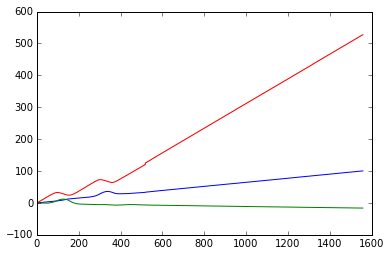

In [171]:
from datetime import timedelta
# print tsecs
dts = np.asarray([dt.microseconds / 1e6 for dt in np.diff(tsecs)]).reshape(-1,1)
'一重积分，v=prev_v+a*dt; v0=0'
vels = [np.array([0,0,0])]
'二重积分, s = prev_s (v(i-1) + v(i)) * dt; s0=0'
ss = [np.array([0,0,0])]
for i, dt in enumerate(dts):
    acc = accs[i]
    prev_vel = vels[i]
    prev_s = ss[i]
    vel = prev_vel + acc * dt
    s = prev_s + (prev_vel + vel) * dt / 2
    
    vels.append(vel)
    ss.append(s)
    pass
vels = np.asarray(vels)
ss = np.asarray(ss)
plot(vels)

# vels = accs[:-1] * dts
# vels = np.append(0, vels)

# dt=(tsecs[2]-tsecs[0])
# dt.microseconds / 1e3


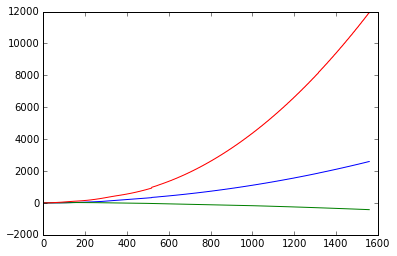

In [174]:
plot(ss)

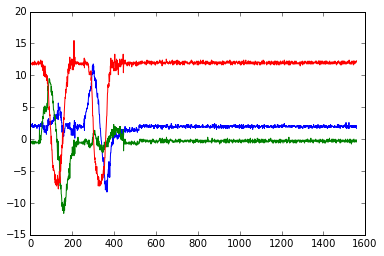

In [154]:
plot(accs)

In [249]:
'尝试 py 中 3d-plot {R,t}'
# 1. 绝对路径加载 module，方式一：
# import imp
# tf = imp.load_source('tf', r'D:\opencv249\sources\modules\python\test\transformations.py')

# 2.
import sys
sys.path.append(r'D:\opencv249\sources\modules\python\test')

import transformations as tf
'一些短别名:'
tf.e2m = tf.euler_matrix
tf.m2e = tf.euler_from_matrix
tf.q2m = tf.quaternion_matrix
tf.m2q = tf.quaternion_from_matrix
tf.e2q = tf.quaternion_from_euler
tf.q2e = tf.euler_from_quaternion
tf.m2r = tf.rotation_from_matrix
tf.r2m = tf.rotation_matrix

'angle <--> radian:'
a2r = np.pi / 180
r2a = 180 / np.pi

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
def plotPoses(quats):
    fig = figure()
    ax = fig.gca(projection='3d')

    factor = 0.1
    # for i, q in enumerate([quats[3]]):
    for i, q in enumerate(quats[100:]):
        rotmat = tf.q2m([q[1], q[2], q[3], q[0]])[:3, :3]
    #     print rotmat
        '暂时全画到原点'
        t = np.zeros((3,3)) + i * factor
        '三条轴线'
        cs='rgb'
        for i in range(3):
            a = rotmat[:, i]
            orig = t[:, i]
            plot(*(zip(orig, orig + a) + [cs[i]]))
        pass
        pause(1e-2)
    pass

plotPoses(quats)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [248]:
pause?

In [240]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = figure()
ax = fig.gca(projection='3d')

factor = 0.1
# for i, q in enumerate([quats[3]]):
for i, q in enumerate(quats[100:]):
    rotmat = tf.q2m([q[1], q[2], q[3], q[0]])[:3, :3]
#     print rotmat
    '暂时全画到原点'
    t = np.zeros((3,3)) + i * factor
    '三条轴线'
    cs='rgb'
    for i in range(3):
        a = rotmat[:, i]
        orig = t[:, i]
        plot(*(zip(orig, orig + a) + [cs[i]]))
    pass
    pause(0.06)
pass


KeyboardInterrupt: 

In [231]:
rotmat[:2, :2]


array([[ 0.99988455,  0.01519512],
       [-0.01519504,  0.9998787 ]])

In [195]:
zip(orig, a)

[(0.0, 0.13570886172198657),
 (0.0, -0.21550610294306063),
 (0.0, 0.96702648590636742)]

In [196]:
rotmat

array([[ 0.97780497, -0.15962628,  0.13570886,  0.        ],
       [ 0.18639258,  0.95854834, -0.2155061 ,  0.        ],
       [-0.09568307,  0.23601806,  0.96702649,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [178]:
pause?

In [54]:
ts='2015-09-01 17:58:14.090'
from datetime import datetime
import dateutil
# datetime.datetime.strptime(ts)
print dateutil.parser.parse(ts)

2015-09-01 17:58:14.090000
